# **Time-Series Forecasting on the S&P 500**

In this guided project, we'll be taking on the role of a trader on the S&P 500 futures desk. Our goal is to build a successful model to forecast how this index will move based on its past behavior. If we can make successful predictions, we can trade these futures effectively and lucratively. Indeed we are learning data science "for fun and profit!"

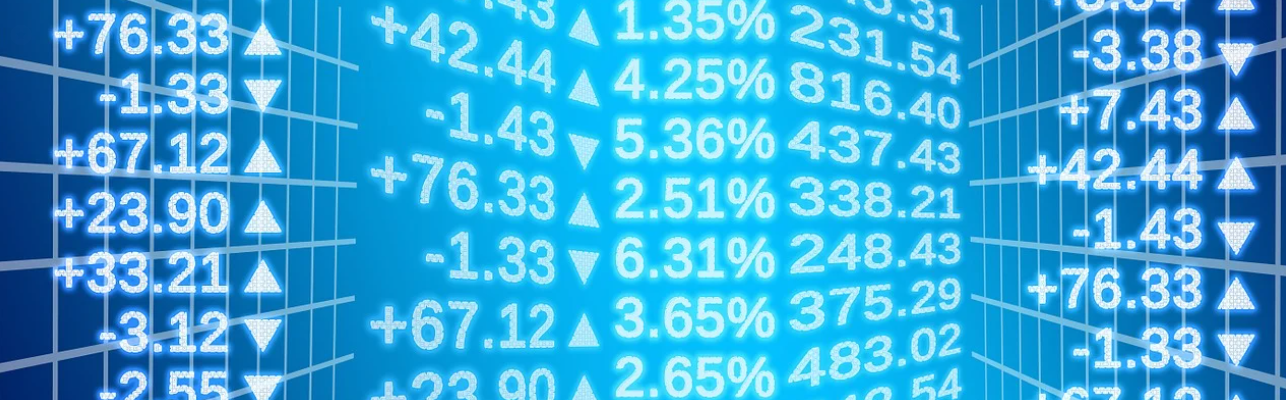

## **Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import r2_score
import matplotlib.dates as mdates

## **1. Dataset Used**

To get started, we'll first need to take a look at the dataset we'll be using. It's from Yahoo Finance via Kaggle and contains S&P 500 Index prices from 2015 through 2020. The file is stored in your workspace as yahoo_stock.csv.

We'll be walking through the steps to load, clean, and explore this dataset first, since the dataset we're starting from is raw and hasn't had any preprocessing applied to it yet. Then we'll go through the specifics for preparing this dataset for a time series forecast with RNNs, including creating the time windows like we did in the previous lesson. Once the data is prepared, we'll build, train, and evaluate several forecasting models until we have achieved satisfactory performance. Finally, we'll take what we've built and visualize the output so we can see how successful our trading strategy is going to be!

## **2. Data Wrangling and Exploration**

First, we will load the dataset into our notebook and inspect the data for any data quality issues. At a minimum, we should check for:

- Missing values
- Outliers
- Whether the data is sorted by the Date column — this is essential for time series forecasting!

### **Features**

- Open: the opening value of the index on that day
- High: the highest value of the index on that day
- Low: the lowest value of the index on that day
- Close: the closing value of the index on that day
- Volume: the total volume of the index traded on that day
- Adj Close: the closing value of the index on that day adjusted for dividends

### **Import Dataset**

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("arashnic/time-series-forecasting-with-yahoo-stock-price")

print("Path to dataset files:", path)

df = pd.read_csv("yahoo_stock.csv")

Path to dataset files: C:\Users\jruiz\.cache\kagglehub\datasets\arashnic\time-series-forecasting-with-yahoo-stock-price\versions\3


### **Check Missing Values**

In [3]:
df.isna().sum()

Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

### **Check Outliers**

In [4]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['Adj Close'].quantile(0.25)
Q3 = df['Adj Close'].quantile(0.75)
IQR = Q3 - Q1  # Interquartile Range

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = df[(df['Adj Close'] < lower_bound) | (df['Adj Close'] > upper_bound)]
print("Outliers:")
print(outliers)

Outliers:
Empty DataFrame
Columns: [Date, High, Low, Open, Close, Volume, Adj Close]
Index: []


In [5]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['Volume'].quantile(0.25)
Q3 = df['Volume'].quantile(0.75)
IQR = Q3 - Q1  # Interquartile Range

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = df[(df['Volume'] < lower_bound) | (df['Volume'] > upper_bound)]
print("Outliers:")
print(outliers)

Outliers:
            Date         High          Low         Open        Close  \
4     2015-11-27  2093.290039  2084.129883  2088.820068  2090.110107   
5     2015-11-28  2093.290039  2084.129883  2088.820068  2090.110107   
6     2015-11-29  2093.290039  2084.129883  2088.820068  2090.110107   
25    2015-12-18  2040.810059  2005.329956  2040.810059  2005.550049   
26    2015-12-19  2040.810059  2005.329956  2040.810059  2005.550049   
...          ...          ...          ...          ...          ...   
1761  2020-09-18  3362.270020  3292.399902  3357.379883  3319.469971   
1762  2020-09-19  3362.270020  3292.399902  3357.379883  3319.469971   
1763  2020-09-20  3362.270020  3292.399902  3357.379883  3319.469971   
1813  2020-11-09  3645.989990  3547.479980  3583.040039  3550.500000   
1814  2020-11-10  3557.219971  3511.909912  3543.260010  3545.530029   

            Volume    Adj Close  
4     1.466840e+09  2090.110107  
5     1.466840e+09  2090.110107  
6     1.466840e+09  209

We can assume some outliers in volume as SYP500 is a volatile fund

### **Drop Non-Used Columns**

In [6]:
df=df.drop(["High","Low","Open","Close","Volume"],axis=1)

In [7]:
df

,Date,Adj Close
0,2015-11-23,2086.590088
1,2015-11-24,2089.139893
2,2015-11-25,2088.870117
3,2015-11-26,2088.870117
4,2015-11-27,2090.110107
...,...,...
1820,2020-11-16,3626.909912
1821,2020-11-17,3609.530029
1822,2020-11-18,3567.790039
1823,2020-11-19,3581.870117


### **Previous Visualizations**

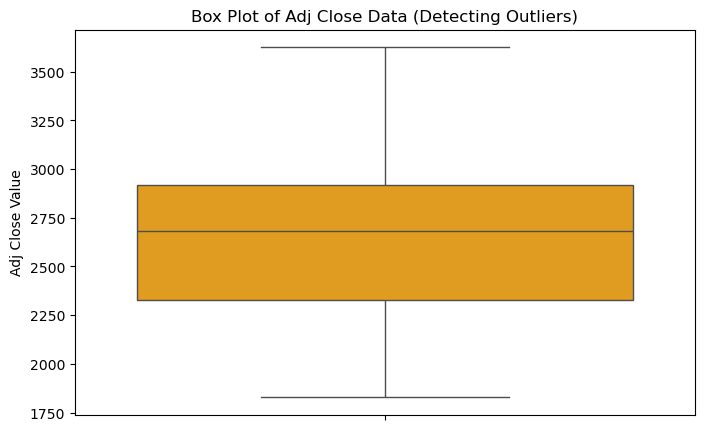

In [8]:
# Create a box plot
plt.figure(figsize=(8, 5))
sns.boxplot(y=df['Adj Close'],color="orange")

# Add title and labels
plt.title("Box Plot of Adj Close Data (Detecting Outliers)")
plt.ylabel("Adj Close Value")

# Show the plot
plt.show()

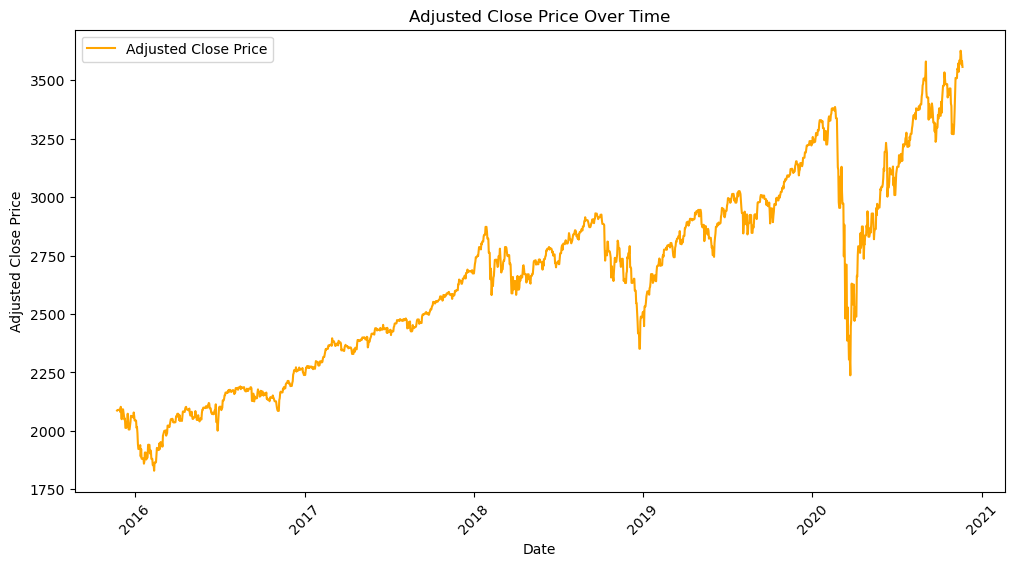

In [9]:
# Convert Date to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort by Date
df = df.sort_values(by='Date')

# Create line plot
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Adj Close'], label='Adjusted Close Price', color='orange')

# Labels and title
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.title("Adjusted Close Price Over Time")
plt.legend()

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show plot
plt.show()


## **3. Data Preprocessing**

In [10]:
# Define split sizes
train_size = int(0.7 * len(df))  # First 70%
val_size = int(0.15 * len(df))  # Next 15%
test_size = len(df) - train_size - val_size  # Remaining 15%

# Create the splits
train_df = df.iloc[:train_size]  # First 70%
val_df = df.iloc[train_size:train_size + val_size]  # Next 15%
test_df = df.iloc[train_size + val_size:]  # Remaining 15%


In [11]:
# Initialize the scaler
scaler = MinMaxScaler()

# Fit the scaler only on the training set
train_df_scaled = train_df.copy()
val_df_scaled = val_df.copy()
test_df_scaled = test_df.copy()

train_df_scaled['Adj Close'] = scaler.fit_transform(train_df[['Adj Close']])

# Transform validation and test sets using the same scaler
val_df_scaled['Adj Close'] = scaler.transform(val_df[['Adj Close']])
test_df_scaled['Adj Close'] = scaler.transform(test_df[['Adj Close']])

train_df_scaled.set_index(train_df_scaled.columns[0], inplace=True)
val_df_scaled.set_index(val_df_scaled.columns[0], inplace=True)
test_df_scaled.set_index(test_df_scaled.columns[0], inplace=True)


In [12]:
def create_dataset(orig_dataset, window_size=1):
    data_x, data_y = [], []
    for i in range(len(orig_dataset) - window_size - 1):
        window = orig_dataset.iloc[i:(i + window_size), 0]
        target = orig_dataset.iloc[i + window_size, 0]
        data_x.append(window)
        data_y.append(target)
    return np.array(data_x), np.array(data_y)

In [13]:
X_train,y_train=create_dataset(train_df_scaled, window_size=1)
X_val,y_val=create_dataset(val_df_scaled, window_size=1)
X_test,y_test=create_dataset(test_df_scaled, window_size=1)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))





## **4. Build and Train a Basic RNN Model**

In [14]:
model = tf.keras.Sequential()
model.add(layers.SimpleRNN(10,input_shape=(1, 1),activation="relu"))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

model.fit(X_train, y_train)

# Train the model
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_val)
print(r2_score(y_val, y_pred))


c:\Users\jruiz\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 10)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241 (964.00 B)

 Trainable params: 241 (964.00 B)

 Non-trainable params: 0 (0.00 B)

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3622
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2264
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
-29.462487936981017


Yikes! That R-Squared score is not looking very good. Let's see if we can improve upon this model.

## **5. Build and Train an LSTM Model**

In [15]:
model = tf.keras.Sequential()
model.add(layers.LSTM(10,input_shape=(1, 1),activation="relu"))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

model.fit(X_train, y_train)

# Train the model
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_val)
print(r2_score(y_val, y_pred))

c:\Users\jruiz\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 601 (2.35 KB)

 Trainable params: 601 (2.35 KB)

 Non-trainable params: 0 (0.00 B)

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3107
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1970
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
-26.23600518738504


That didn't improve things like we hoped. For now, let's keep the LSTM in place until we're ready to fully optimize the model, and we can decide then whether it's worth keeping. For now, let's move onto the next section to see what other techniques we can try to improve this model.

## **6. Add a Convolutional Layer**

In [16]:
# Build the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv1D(64, 1, activation="relu", input_shape=(1, 1)))
model.add(tf.keras.layers.MaxPooling1D(1))
model.add(tf.keras.layers.LSTM(10, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Train the model
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_val)
print(r2_score(y_val, y_pred))

c:\Users\jruiz\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 64)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10)             │         3,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,249 (12.69 KB)

 Trainable params: 3,249 (12.69 KB)

 Non-trainable params: 0 (0.00 B)

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.3643
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
-40.58704700320578


These are still pretty terrible results. Let's go further and try modifying other model parameters to fully optimize this model, at which point we may or may not keep the convolutional layer.

## **7. Optimize the Model**

Now we can go further to optimize this model by adding layers, changing the number of nodes in each layer, increasing the number of training epochs, and modifying the window size.

In [17]:
# Set the desired window size
window_size = 25

X_train,y_train=create_dataset(train_df_scaled, window_size)
X_val,y_val=create_dataset(val_df_scaled, window_size)
X_test,y_test=create_dataset(test_df_scaled, window_size)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Build the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv1D(128, 1, activation="relu", input_shape=(1, window_size)))
model.add(tf.keras.layers.MaxPooling1D(1))
model.add(tf.keras.layers.LSTM(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Train the model
model.fit(X_train, y_train, epochs=35)

# Make predictions and evaluate
y_pred = model.predict(X_val)
print(f"\nR-Squared value on validation set: {r2_score(y_val, y_pred)}")

c:\Users\jruiz\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 1, 128)         │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,361 (216.25 KB)

 Trainable params: 55,361 (216.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2948
Epoch 2/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069
Epoch 3/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027
Epoch 4/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022
Epoch 5/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018
Epoch 6/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014
Epoch 7/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011
Epoch 8/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.0252e-04
Epoch 9/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.8130e-04
Epoch 10/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.6737e-04
Epoch 11/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.9798e-04
Epoch 12/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.6655e-04
Epoch 13/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7392e-04
Epoch 14/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3806e-04
Epoch 15/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss

Overall, this is starting to look really good! We are achieving an R-Squared value between 0.90 and 0.95 on the validation set, which is impressive. As a final performance check, we should now compute and visualize the performance on the testing set.

## **8. Evaluate Model Performance**

In [18]:
# Make predictions on all three sets
train_pred = model.predict(X_train)
validation_pred = model.predict(X_val)
test_pred = model.predict(X_test)

print(r2_score(y_train, train_pred), " --> Training Set")
print(r2_score(y_val, validation_pred), " --> Validation Set")
print(r2_score(y_test, test_pred), " --> Test Set")

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
0.9954591063823235  --> Training Set
0.9750512902902334  --> Validation Set
0.9610654890072451  --> Test Set


In [19]:
df = df.set_index("Date")

# Un-scale the predictions
train_pred = scaler.inverse_transform(train_pred)
validation_pred = scaler.inverse_transform(validation_pred)
test_pred = scaler.inverse_transform(test_pred)

# Un-window the training predictions
plot_train_pred = np.empty((len(df), 1))
plot_train_pred[:] = np.nan
plot_train_pred[window_size:len(train_pred) + window_size, :] = train_pred

# Un-window the validation predictions
plot_validation_pred = np.empty((len(df), 1))
plot_validation_pred[:] = np.nan
plot_validation_pred[len(train_pred) + (window_size * 2) + 1:len(train_pred) + len(validation_pred) + (window_size * 2) + 1, :] = validation_pred

# Un-window the test predictions
plot_test_pred = np.empty((len(df), 1))
plot_test_pred[:] = np.nan
plot_test_pred[len(train_pred) + len(validation_pred) + (window_size * 3) + 2:len(df) - 1, :] = test_pred

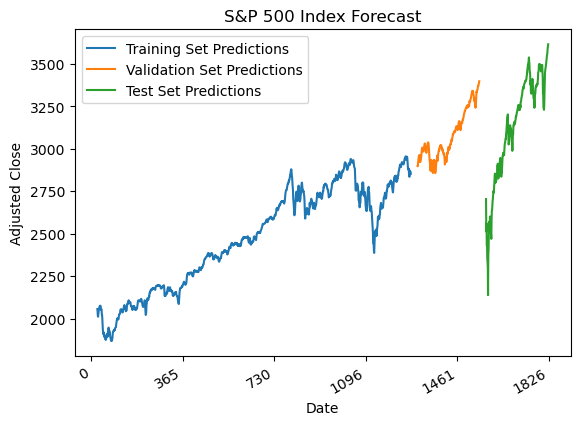

In [32]:


# Plot the predictions
plt.plot(plot_train_pred, label="Training Set Predictions")
plt.plot(plot_validation_pred, label="Validation Set Predictions")
plt.plot(plot_test_pred, label="Test Set Predictions")

# Add title, axis labels, and a legend
plt.title('S&P 500 Index Forecast')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()
plt.ylabel('Adjusted Close')
plt.legend()
plt.show()

In [27]:
np.savetxt("my_array.txt", plot_train_pred)